<a href="https://colab.research.google.com/github/EzyHow/ML-Deep-Learning-GenAI/blob/main/13_Stock_Price_Prediction_Nifty_50_On_High_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from copy import deepcopy

import matplotlib.pyplot as plt


from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

from google.colab import files

# Load Dataset

In [ ]:
!wget https://raw.githubusercontent.com/AshishJangra27/ai-projects/refs/heads/main/Stock%20Price%20Prediction%20Nifty-50/data.csv

--2025-09-21 06:53:53--  https://raw.githubusercontent.com/AshishJangra27/ai-projects/refs/heads/main/Stock%20Price%20Prediction%20Nifty-50/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264243 (258K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 258.05K  --.-KB/s    in 0.02s   

2025-09-21 06:53:53 (10.8 MB/s) - ‘data.csv’ saved [264243/264243]



In [ ]:
df = pd.read_csv('data.csv')
df.head()

,Date,Open,High,Low,Close
0,2000-01-03,1482.15,1592.90,1482.15,1592.2
1,2000-01-04,1594.40,1641.95,1594.40,1638.7
2,2000-01-05,1634.55,1635.50,1555.05,1595.8
3,2000-01-06,1595.80,1639.00,1595.80,1617.6
4,2000-01-07,1616.60,1628.25,1597.20,1613.3


# Preprocess Dataset

In [ ]:
def return_pairs(column, days):
    pricess = list(column)
    X = []
    y = []
    for i in range(len(pricess) - days):
        X.append(pricess[i:i+days])
        y.append(pricess[i+days])
    return np.array(X), np.array(y)

target_columns = ['High']  # ['Open', 'Close', 'High', 'Low']
day_chunks =  [30, 60, 90] # [30, 45, 60, 90, 120, 150 ,200, 250]

chunked_data = {}

for col in target_columns:
    for days in day_chunks:
        key_X = f"X_{col}_{days}"
        key_y = f"y_{col}_{days}"
        X, y = return_pairs(df[col], days)
        chunked_data[key_X] = X
        chunked_data[key_y] = y


chunk_pairs = []

for key in chunked_data.keys():
    if key.startswith("X_"):
        y_key = key.replace("X_", "y_")
        if y_key in chunked_data:
            chunk_pairs.append([key, y_key])

chunk_pairs

[['X_High_30', 'y_High_30'],
 ['X_High_60', 'y_High_60'],
 ['X_High_90', 'y_High_90']]

# Define Models

*   **Models:**
    *   KNN (K-Nearest Neighbors Regressor)
    *   RNN (Simple Recurrent Neural Network)
    *   GRU (Gated Recurrent Unit)
    *   LSTM (Long Short-Term Memory)
    *   Bidirectional LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional


def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)   # regression output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
ml_models = [
    ("KNN", KNeighborsRegressor())
]

dl_models = {
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "Bidirectional_LSTM": build_bilstm
}

# Model Training

In [ ]:
trained_models = {}

for X, y in tqdm(chunk_pairs):
    X_data = chunked_data[X]
    y_data = chunked_data[y]

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    # ML models
    for model_name, model in tqdm(ml_models):
        key = model_name + '_' + X[2:]
        model_copy = deepcopy(model)
        model_copy.fit(X_train, y_train)

        y_train_pred = model_copy.predict(X_train)
        y_test_pred = model_copy.predict(X_test)

        trained_models[key] = {
            'model': model_copy,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

    # DL models
    X_train_rnn = np.expand_dims(X_train, -1)
    X_test_rnn = np.expand_dims(X_test, -1)

    for model_name, builder in tqdm(dl_models.items()):
        key = model_name + '_' + X[2:]
        model_dl = builder((X_train.shape[1], 1))

        model_dl.fit(X_train_rnn, y_train, epochs=50, batch_size=8, verbose=1)

        y_train_pred = model_dl.predict(X_train_rnn).flatten()
        y_test_pred = model_dl.predict(X_test_rnn).flatten()

        trained_models[key] = {
            'model': model_dl,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 102435656.0000
Epoch 2/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 102269408.0000
Epoch 3/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 101568936.0000
Epoch 4/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 100158704.0000
Epoch 5/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 101953480.0000
Epoch 6/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 98381736.0000
Epoch 7/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 99581368.0000
Epoch 8/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 97938520.0000
Epoch 9/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 97206720.0000
Epoch 10/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 98013104.0000
Epoch 11/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 97023112.0000
Epoch 12/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 101537176.0000
Epoch 13/50
707/707 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 94858304.0000
Epoch 14/50
707/707 ━━━━━━━━

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 101165648.0000
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 100357040.0000
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 101858312.0000
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 99040320.0000
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 100343104.0000
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 103974088.0000
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 100981248.0000
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 100970464.0000
Epoch 9/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 99333232.0000
Epoch 10/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 97675168.0000
Epoch 11/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 95861992.0000
Epoch 12/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 98288792.0000
Epoch 13/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 98927416.0000
Epoch 14/50
704/704 ━━━━━━━

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 101140904.0000
Epoch 2/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 102498832.0000
Epoch 3/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 101905088.0000
Epoch 4/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 103371312.0000
Epoch 5/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 100382584.0000
Epoch 6/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 98685240.0000
Epoch 7/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 99025520.0000
Epoch 8/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 100510816.0000
Epoch 9/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 97682080.0000
Epoch 10/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 99279496.0000
Epoch 11/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 95216104.0000
Epoch 12/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 98479056.0000
Epoch 13/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 98597552.0000
Epoch 14/50
701/701 ━━━━━━━━

# Model Statistics

In [ ]:
results_df = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in trained_models.items()])

results_df.sort_values(by = 'test_mae', ascending = True).head(50)

,Model,model,train_mae,train_rmse,test_mae,test_rmse
10,KNN_High_90,KNeighborsRegressor(),36.929140,58.769966,48.790144,74.204848
5,KNN_High_60,KNeighborsRegressor(),36.850899,58.333589,52.819089,82.674612
0,KNN_High_30,KNeighborsRegressor(),42.646429,68.669169,56.933037,89.679421
1,RNN_High_30,"<Sequential name=sequential_4, built=True>",6388.130393,8842.063908,5891.001174,8445.609215
6,RNN_High_60,"<Sequential name=sequential_8, built=True>",6419.391949,8878.381100,5963.945761,8380.949509
11,RNN_High_90,"<Sequential name=sequential_12, built=True>",6433.525535,8881.448822,6156.098099,8598.484282
4,Bidirectional_LSTM_High_30,"<Sequential name=sequential_7, built=True>",6907.689635,9328.727924,6389.121426,8914.725363
9,Bidirectional_LSTM_High_60,"<Sequential name=sequential_11, built=True>",6930.797997,9357.427952,6449.333126,8850.898820
8,GRU_High_60,"<Sequential name=sequential_10, built=True>",7023.828039,9429.086941,6542.473307,8921.418228
14,Bidirectional_LSTM_High_90,"<Sequential name=sequential_15, built=True>",6846.247596,9277.673589,6550.050519,8988.839822


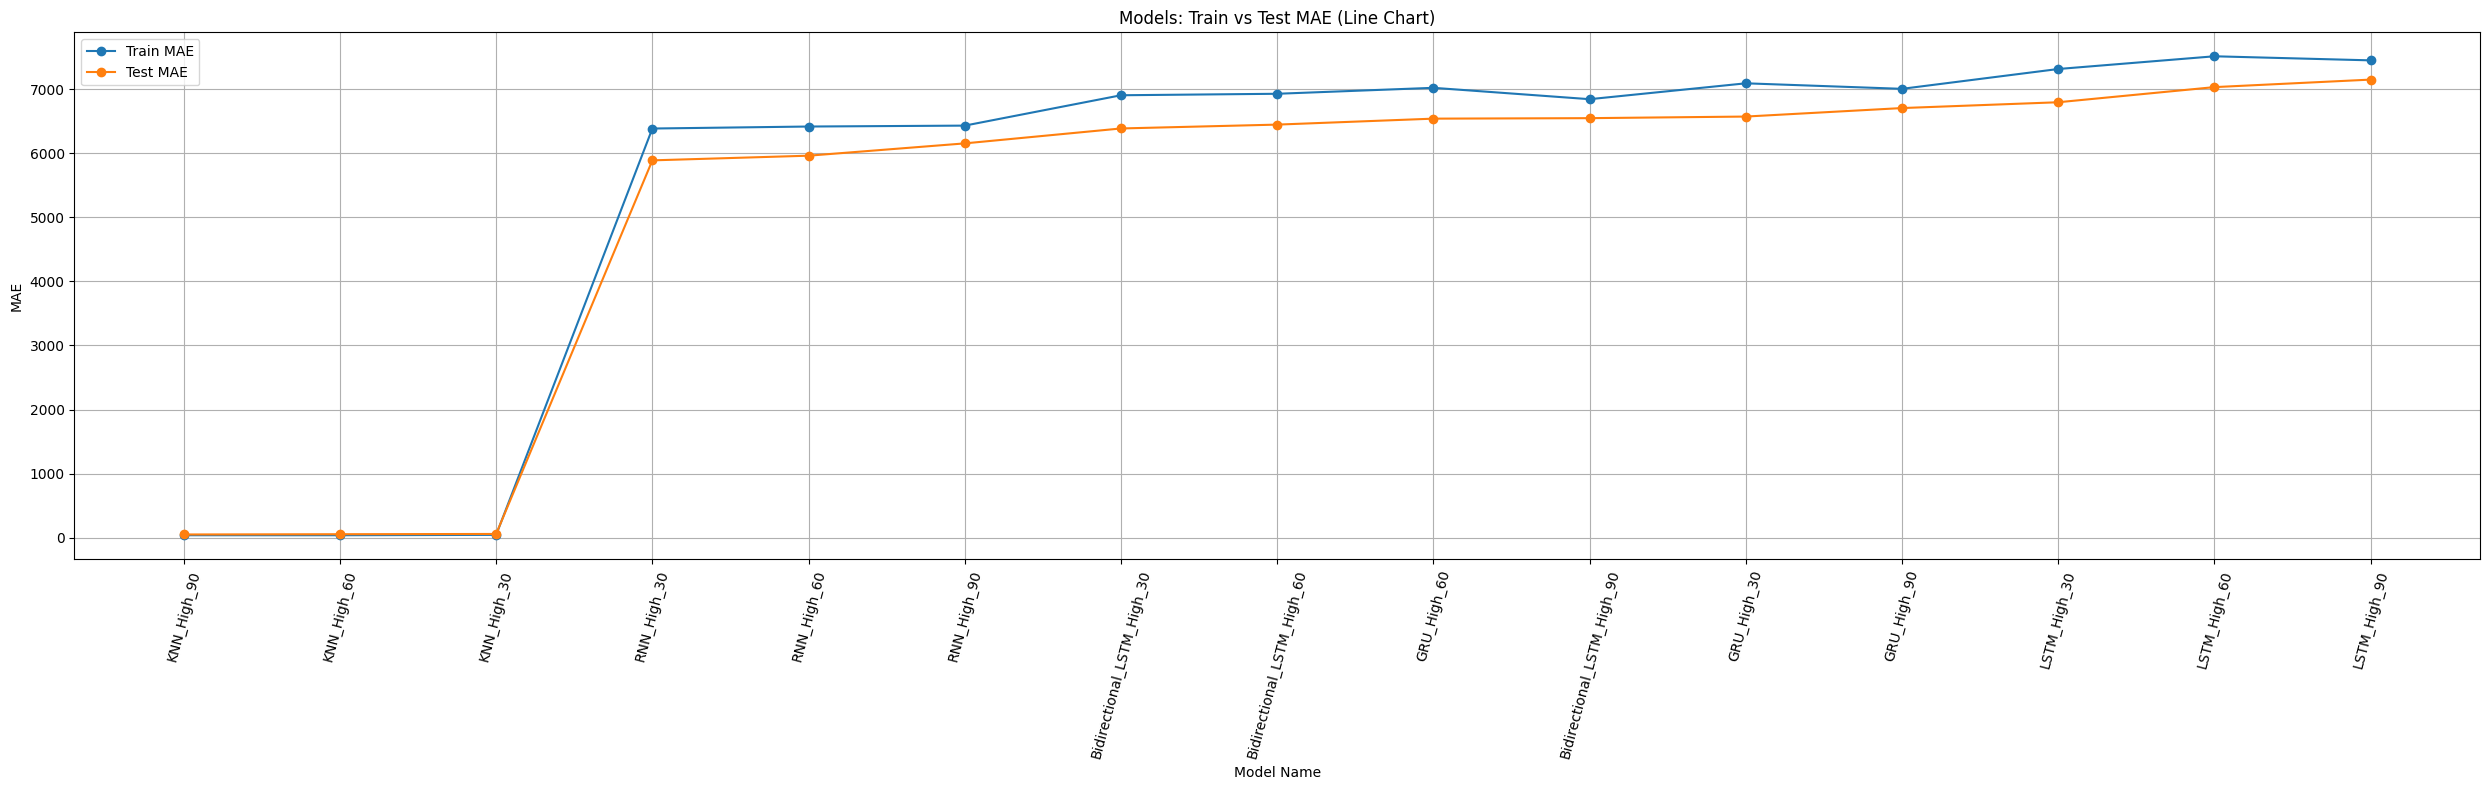

In [ ]:
results_df.sort_values(by='test_mae', ascending=True, inplace=True)
results_df.reset_index(drop=True, inplace=True)
plt.figure(figsize=(25, 8))
plt.plot(results_df['Model'], results_df['train_mae'], marker='o', label='Train MAE')

plt.plot(results_df['Model'], results_df['test_mae'], marker='o', label='Test MAE')

plt.xticks(rotation=75)
plt.xlabel('Model Name')
plt.ylabel('MAE')
plt.title('Models: Train vs Test MAE (Line Chart)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Relation btw. No of Input Days and Model Performance

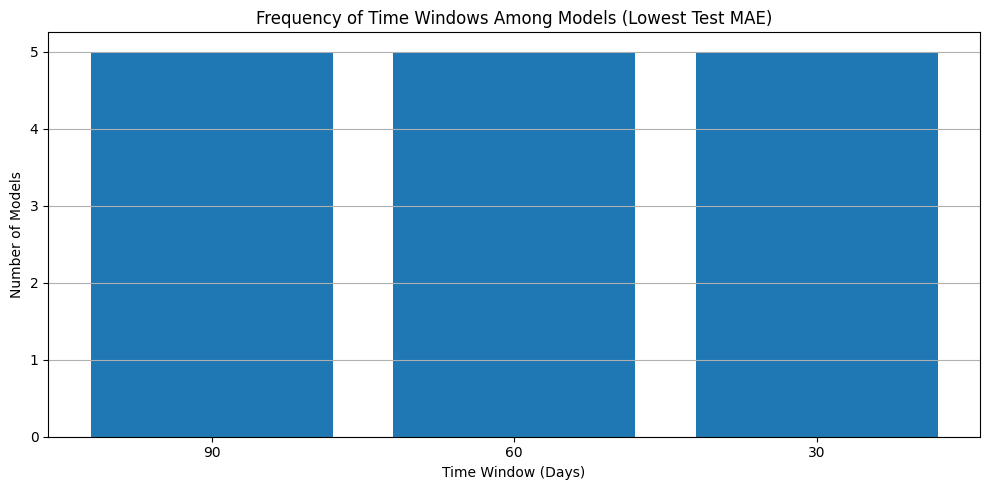

In [ ]:
results_df.sort_values(by='test_mae', ascending=True, inplace=True)
results_df.reset_index(drop=True, inplace=True)
time_windows = pd.Series([i.split('_')[-1] for i in results_df['Model']])
time_counts = time_windows.value_counts().sort_values(ascending=False)  # Sort by count

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(time_counts.index, time_counts.values)

# Labels and aesthetics
plt.xlabel('Time Window (Days)')
plt.ylabel('Number of Models')
plt.title('Frequency of Time Windows Among Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()